Run download_mabe2022.ipynb first

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
aicrowd_challenge_name = "mabe-2022-mouse-triplets"
data_dir = os.path.join('../data', aicrowd_challenge_name)

## Dataset Specifications 💾

We provide frame-by-frame animal pose estimates extracted from top-view videos of trios of interacting mice filmed at 30Hz; raw videos will not be provided for this stage of the competition. Animal poses are characterized by the tracked locations of body parts on each animal, termed "keypoints."

The following files are available in the `resources` section. A "sequence" is a continuous recording of social interactions between animals: sequences are 1 minute long (1800 frames at 30Hz) in the mouse dataset. The `sequence_id` is a random hash to anonymize experiment details.


- `user_train.npy` - Training set for the task, which follows the following schema :

```
{
    "sequences" : {
        "<sequence_id> : {
            "keypoints" : a ndarray of shape (4500, 11, 24, 2)
        }
    }
}
```

- `submission_clips.npy` - Test set for the task, which follows the following schema:

```
{
    "<sequence_id> : {
        "keypoints" : a ndarray of shape (4500, 11, 24, 2)
    }
}
```
- sample_submission.npy - Template for a sample submission for this task, follows the following schema :

```
{
    "frame_number_map":
        {"<sequence_id-1>": (start_frame_index, end_frame_index),
        "<sequence_id-1>": (start_frame_index, end_frame_index),
        ...
        "<sequence_id-n>": (start_frame_index, end_frame_index),
        }
    "<sequence_id-1>" : [
            [0.321, 0.234, 0.186, 0.857, 0.482, 0.185], .....]
            [0.184, 0.583, 0.475], 0.485, 0.275, 0.958], .....]
        ]
}
```

In `sample_submission`, each key in the `frame_number_map` dictionary refers to the unique sequence id of a video in the test set. The item for each key is expected to be an the start and end index for slicing the `embeddings` numpy array to get the corresponding embeddings. The `embeddings` array is a 2D `ndarray` of floats of size `total_frames` by `X` , where `X` is the dimension of your learned embedding (6 in the above example; maximum permitted embedding dimension is **128**), representing the embedded value of each frame in the sequence. `total_frames` is the sum of all the frames of the sequences, the array should be concatenation of all the embeddings of all the clips.

Keypoints are stored in an ndarray with the following properties:

- Dimensions: (`# frames`) x (`animal ID`) x (`body part`) x (`x, y coordinate`).
- Units: pixels; coordinates are relative to the entire image. Original image dimensions are **850 x 850** for the mouse dataset.

Body parts are ordered: **1) nose, 2) left ear, 3) right ear, 4) neck, 5) left forepaw, 6) right forepaw, 7) center back, 8) left hindpaw, 9) right hindpaw, 10) tail base, 11) tail middle, 12) tail tip**.

The placement of these keypoints is illustrated below:
![diagram of keypoint locations](https://images.aicrowd.com/uploads/ckeditor/pictures/702/content_keypoint_ids_mouse.png)

In [4]:
submission_clips = np.load(os.path.join(data_dir, 'submission_data.npy'),
                           allow_pickle=True).item()
user_train = np.load(os.path.join(data_dir, 'user_train.npy'),
                     allow_pickle=True).item()

In [5]:
print("Dataset keys - ", submission_clips.keys())
print("Number of submission sequences - ", len(submission_clips['sequences']))

Dataset keys -  dict_keys(['sequences'])
Number of submission sequences -  3736


In [6]:
sequence_names = list(submission_clips["sequences"].keys())
sequence_key = sequence_names[0]
single_sequence = submission_clips["sequences"][sequence_key]["keypoints"]
print("Sequence name - ", sequence_key)
print("Single Sequence shape ", single_sequence.shape)
print(f"Number of Frames in {sequence_key} - ", len(single_sequence))

Sequence name -  0D2SPY7EPE05CRPC8DP0
Single Sequence shape  (1800, 3, 12, 2)
Number of Frames in 0D2SPY7EPE05CRPC8DP0 -  1800


In [7]:
single_sequence[0]

array([[[ 63, 177],
        [ 68, 164],
        [ 64, 180],
        [ 74, 171],
        [ 74, 162],
        [ 76, 177],
        [111, 161],
        [114, 150],
        [ 98, 184],
        [132, 184],
        [139, 130],
        [137, 192]],

       [[ 66, 132],
        [ 56,  97],
        [ 89, 102],
        [ 73, 100],
        [ 60, 116],
        [ 80, 118],
        [ 74,  85],
        [ 58,  88],
        [ 86,  97],
        [ 83,  78],
        [139, 129],
        [168, 120]],

       [[  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0]]], dtype=int32)

In [8]:
"""Body parts are ordered: **1) nose, 2) left ear, 3) right ear, 4) neck, 5) left forepaw, 6) right forepaw, 7) center back, 8) left hindpaw, 9) right hindpaw, 10) tail base, 11) tail middle, 12) tail tip**."""

bodyparts = ['nose_x', 'nose_y', 'left_ear_x','left_ear_y',
             'right_ear_x', 'right_ear_y', 'neck_x', 'neck_y',
             'left_forepaw_x', 'left_forepaw_y', 'right_forepaw_x', 'right_forepaw_y', 'center_back_x', 'center_back_y', 'left_hindpaw_x', 'left_hindpaw_y', 'right_hindpaw_x', 'right_hindpaw_y', 'tail_base_x', 'tail_base_y',
             'tail_middle_x', 'tail_middle_y', 'tail_tip_x', 'tail_tip_y']
meta_cols = ['frame', 'animal_code']

animal_codes = []
frames = []
tracking_data = []

downsample_framerate = 10
downsample_sequences = 100

for i, sequence_key in enumerate(sequence_names[:downsample_sequences]): ## down sample

    sequence = submission_clips["sequences"][sequence_key]["keypoints"]

    a0, a1, a2 = [], [], []
    for frameS in sequence[::downsample_framerate]: ## down sample
        b0 = frameS[0]
        b1 = frameS[1]
        b2 = frameS[2]

        a0.append(b0.flatten())
        a1.append(b1.flatten())
        a2.append(b2.flatten())

    for i, a in enumerate([a0, a1, a2]):
        for j, frame in enumerate(a):
            animal_codes.append(str(i) + '_' + sequence_key)
            frames.append(j)
            tracking_data.append(frame.astype('float32'))

df = pd.DataFrame(list(zip(frames, animal_codes)),
                  columns = meta_cols)
for i, bodypart in enumerate(bodyparts):
    df[bodypart] = [x[i] for x in tracking_data]

In [9]:
frameS[0]

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)

In [10]:
frameS[0].flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [11]:
tracking_data[0]

array([ 63., 177.,  68., 164.,  64., 180.,  74., 171.,  74., 162.,  76.,
       177., 111., 161., 114., 150.,  98., 184., 132., 184., 139., 130.,
       137., 192.], dtype=float32)

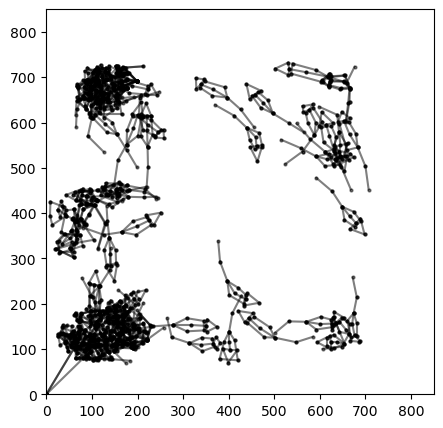

In [12]:
PLOT_MOUSE_START_END = [(0, 1), (1, 3), (3, 2), (2, 0),        # head
                        (3, 6), (6, 9),                        # midline
                        (9, 10), (10, 11),                     # tail
                        (4, 5), (5, 8), (8, 9), (9, 7), (7, 4) # legs
                       ]

parts = [s.split('_x')[0] for s in bodyparts [::2]]

plotting_pairs = []

for start, end in PLOT_MOUSE_START_END:
    pair = (parts[start] + '_x', parts[start] + '_y',
            parts[end] + '_x', parts[end] + '_y')
    plotting_pairs.append(pair)

fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

ax=ax1
for row in df.iloc[:int(3600*3):100].iterrows():
    row = row[1]
    for pair in plotting_pairs:
        ax.plot([row[pair[0]], row[pair[2]]],
                 [row[pair[1]], row[pair[3]]],
                 color='black', alpha=0.5,
                 marker='o', markersize=2)

ax.set_xlim(0,850)
ax.set_ylim(0, 850)

plt.show(fig)
plt.close(fig)


In [13]:
df

,frame,animal_code,nose_x,nose_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,neck_x,neck_y,...,left_hindpaw_x,left_hindpaw_y,right_hindpaw_x,right_hindpaw_y,tail_base_x,tail_base_y,tail_middle_x,tail_middle_y,tail_tip_x,tail_tip_y
0,0,0_0D2SPY7EPE05CRPC8DP0,63.0,177.0,68.0,164.0,64.0,180.0,74.0,171.0,...,114.0,150.0,98.0,184.0,132.0,184.0,139.0,130.0,137.0,192.0
1,1,0_0D2SPY7EPE05CRPC8DP0,63.0,177.0,69.0,164.0,68.0,171.0,75.0,171.0,...,112.0,150.0,98.0,185.0,132.0,184.0,86.0,188.0,137.0,192.0
2,2,0_0D2SPY7EPE05CRPC8DP0,64.0,178.0,68.0,164.0,67.0,173.0,76.0,170.0,...,112.0,150.0,98.0,180.0,132.0,184.0,86.0,188.0,137.0,192.0
3,3,0_0D2SPY7EPE05CRPC8DP0,62.0,175.0,68.0,164.0,65.0,178.0,74.0,159.0,...,114.0,151.0,98.0,184.0,132.0,184.0,86.0,188.0,137.0,192.0
4,4,0_0D2SPY7EPE05CRPC8DP0,62.0,174.0,68.0,164.0,66.0,179.0,75.0,167.0,...,112.0,149.0,98.0,182.0,132.0,184.0,86.0,188.0,137.0,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,175,2_G1XQ5RO6M8CAVWA81AAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53996,176,2_G1XQ5RO6M8CAVWA81AAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53997,177,2_G1XQ5RO6M8CAVWA81AAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53998,178,2_G1XQ5RO6M8CAVWA81AAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df.columns[2:]

Index(['nose_x', 'nose_y', 'left_ear_x', 'left_ear_y', 'right_ear_x',
       'right_ear_y', 'neck_x', 'neck_y', 'left_forepaw_x', 'left_forepaw_y',
       'right_forepaw_x', 'right_forepaw_y', 'center_back_x', 'center_back_y',
       'left_hindpaw_x', 'left_hindpaw_y', 'right_hindpaw_x',
       'right_hindpaw_y', 'tail_base_x', 'tail_base_y', 'tail_middle_x',
       'tail_middle_y', 'tail_tip_x', 'tail_tip_y'],
      dtype='object')

In [15]:
head_parts = ['nose_x', 'nose_y',
              'left_ear_x', 'left_ear_y',
              'right_ear_x', 'right_ear_y']

head_x = (df[head_parts[0]] + df[head_parts[2]] + df[head_parts[4]])/3
head_y = (df[head_parts[1]] + df[head_parts[3]] + df[head_parts[5]])/3

df['head_x'] = head_x
df['head_y'] = head_y

for part in head_parts:
    df.drop(part, axis=1, inplace=True)

In [16]:
df

,frame,animal_code,neck_x,neck_y,left_forepaw_x,left_forepaw_y,right_forepaw_x,right_forepaw_y,center_back_x,center_back_y,...,right_hindpaw_x,right_hindpaw_y,tail_base_x,tail_base_y,tail_middle_x,tail_middle_y,tail_tip_x,tail_tip_y,head_x,head_y
0,0,0_0D2SPY7EPE05CRPC8DP0,74.0,171.0,74.0,162.0,76.0,177.0,111.0,161.0,...,98.0,184.0,132.0,184.0,139.0,130.0,137.0,192.0,65.000000,173.666672
1,1,0_0D2SPY7EPE05CRPC8DP0,75.0,171.0,74.0,163.0,76.0,177.0,110.0,161.0,...,98.0,185.0,132.0,184.0,86.0,188.0,137.0,192.0,66.666664,170.666672
2,2,0_0D2SPY7EPE05CRPC8DP0,76.0,170.0,67.0,147.0,76.0,177.0,114.0,162.0,...,98.0,180.0,132.0,184.0,86.0,188.0,137.0,192.0,66.333336,171.666672
3,3,0_0D2SPY7EPE05CRPC8DP0,74.0,159.0,70.0,155.0,75.0,177.0,110.0,160.0,...,98.0,184.0,132.0,184.0,86.0,188.0,137.0,192.0,65.000000,172.333328
4,4,0_0D2SPY7EPE05CRPC8DP0,75.0,167.0,68.0,148.0,76.0,177.0,110.0,160.0,...,98.0,182.0,132.0,184.0,86.0,188.0,137.0,192.0,65.333336,172.333328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,175,2_G1XQ5RO6M8CAVWA81AAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
53996,176,2_G1XQ5RO6M8CAVWA81AAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
53997,177,2_G1XQ5RO6M8CAVWA81AAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
53998,178,2_G1XQ5RO6M8CAVWA81AAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


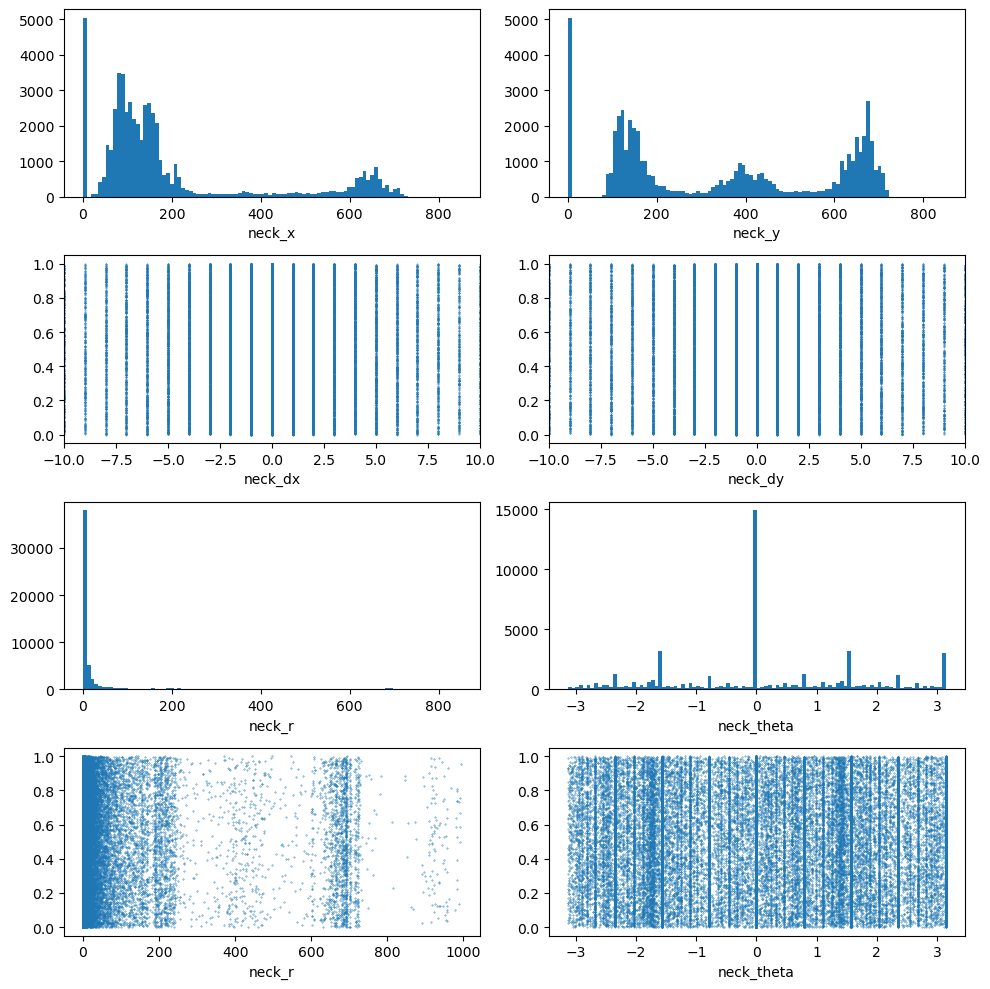

In [17]:
fig, axs = plt.subplots(4, 2, figsize=(10,10))

ax = axs[0,0]
dx = np.diff(df['neck_x'])
ax.hist(df['neck_x'], bins=100, range=(0, 850))
ax.set_xlabel('neck_x')

ax = axs[1,0]
ax.scatter(dx, np.random.rand(len(dx)), s=0.1)
ax.set_xlabel('neck_dx')
ax.set_xlim(-10, 10)

ax = axs[0,1]
dy = np.diff(df['neck_y'])
ax.hist(df['neck_y'], bins=100, range=(0, 850))
ax.set_xlabel('neck_y')

ax = axs[1,1]
ax.scatter(dy, np.random.rand(len(dy)), s=0.1)
ax.set_xlabel('neck_dy')
ax.set_xlim(-10, 10)

r = np.sqrt(dx**2 + dy**2)
theta = np.arctan2(dy, dx)

ax = axs[2,0]
ax.hist(r, bins=100, range=(0, 850))
ax.set_xlabel('neck_r')

ax = axs[2,1]
ax.hist(theta, bins=100)
ax.set_xlabel('neck_theta')

ax = axs[3,0]
ax.scatter(r, np.random.rand(len(r)), s=0.1)
ax.set_xlabel('neck_r')

ax = axs[3,1]
ax.scatter(theta, np.random.rand(len(theta)), s=0.1)
ax.set_xlabel('neck_theta')

fig.tight_layout()

plt.show(fig)
plt.close(fig)

In [18]:
show = False
verbose = False

cols_2_shift = df.columns[2:]

parts = [s.split('_x')[0] for s in cols_2_shift  [::2]]
new_cols = [[s + '_r', s + '_sin', s + '_cos', s + '_dtheta'] for s in parts]
new_cols = [item for sublist in new_cols for item in sublist]

frames = []
animal_codes = []
converted_data = []

np.random.seed(1)

pbar = tqdm(total = len(df.animal_code.unique()), position=0, leave=True)
for animal in df.animal_code.unique():
    cols = df.columns[2:]
    tmp = df[df['animal_code'] == animal]
    if verbose == True:
        print(animal)
        print(tmp.shape)

    converted_data_tmp = []

    m = 0
    for bx, by in zip(cols[::2], cols[1::2]):

        x = tmp[bx]
        y = tmp[by]

        dx = np.diff(x)
        dy = np.diff(y)

        ## convert to polar coordinates ##
        r = np.sqrt(dx**2 + dy**2)
        theta = np.arctan2(dy, dx)

        if m == 0 and show == True:
            if verbose == True:
                print(bx, by)
                print(tmp)
                print('x',x)
                print('y', y)

            fig, axs = plt.subplots(3,2,figsize=(10,5))

            ax = axs[0,0]
            ax.scatter(x, np.random.rand(len(x)), s=0.1)
            ax.set_xlabel(bx)

            ax = axs[0, 1]
            ax.scatter(y, np.random.rand(len(y)), s=0.1)
            ax.set_xlabel(by)

            ax = axs[1,0]
            ax.scatter(dx, np.random.rand(len(dx)), s=0.1)
            ax.set_xlabel(bx + '_dx')
            ax.set_xlim(-10, 10)

            ax = axs[1,1]
            ax.scatter(dy, np.random.rand(len(dy)), s=0.1)
            ax.set_xlabel(by + '_dy')
            ax.set_xlim(-10, 10)

            ax = axs[2,0]
            ax.scatter(r, np.random.rand(len(r)), s=0.1)
            ax.set_xlabel(bx + '_r')

            ax = axs[2,1]
            ax.scatter(theta, np.random.rand(len(theta)), s=0.1)
            ax.set_xlabel(bx + '_theta')

            fig.tight_layout()

            plt.show(fig)
            plt.close(fig)

            m += 1

        ## get angular velocity ##
        dtheta = np.diff(theta)

        ## convert to sin and cos ##
        sin = np.sin(theta)#np.sin(theta)
        cos = np.cos(theta)

        ## convert from -1 to 1 to 0 to 1
        sin = sin[1:]
        cos = cos[1:]

        sin = (sin + 1) / 2
        cos = (cos + 1) / 2

        dtheta = ((dtheta/(2*np.pi))+1)/2

        ## trim r, sin, dtheta to same length ##
        r = r[1:]

        ## normalize r to 0 to 1 ##
        if np.max(r) > 0:
            r = r / np.max(r)

        converted_data_tmp.append(r)
        converted_data_tmp.append(sin)
        converted_data_tmp.append(cos)
        converted_data_tmp.append(dtheta)

    frames_tmp = tmp['frame'].values[2:]
    animal_codes_tmp = tmp['animal_code'].values[2:]

    frames.append(frames_tmp)
    animal_codes.append(animal_codes_tmp)
    converted_data.append(converted_data_tmp)

    pbar.update(1)
pbar.close()

frames = np.concatenate(frames)
animal_codes = np.concatenate(animal_codes)

new_df = pd.DataFrame(list(zip(frames, animal_codes)),
                      columns = meta_cols)

pbar = tqdm(total = len(new_cols), position=0, leave=True)
for i, col in enumerate(new_cols):

    tmpN = []
    for j in range(len(converted_data)):
        tmpN.append(converted_data[j][i])

    tmpN = np.concatenate(tmpN)
    new_df[col] = tmpN

    pbar.update(1)
pbar.close()



100%|██████████| 40/40 [00:00<00:00, 3143.92it/s]


In [19]:
cols[::2], cols[1::2]

(Index(['neck_x', 'left_forepaw_x', 'right_forepaw_x', 'center_back_x',
        'left_hindpaw_x', 'right_hindpaw_x', 'tail_base_x', 'tail_middle_x',
        'tail_tip_x', 'head_x'],
       dtype='object'),
 Index(['neck_y', 'left_forepaw_y', 'right_forepaw_y', 'center_back_y',
        'left_hindpaw_y', 'right_hindpaw_y', 'tail_base_y', 'tail_middle_y',
        'tail_tip_y', 'head_y'],
       dtype='object'))

2
neck_r 0.0 1.0
neck_sin 0.0 1.0
neck_cos 0.0 1.0
neck_dtheta 0.0012834370136260986 0.9987165927886963


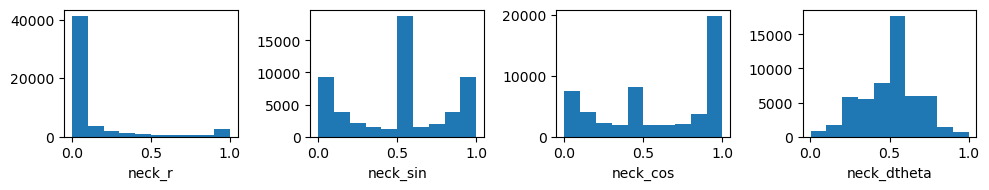

6
left_forepaw_r 0.0 1.0
left_forepaw_sin 0.0 1.0
left_forepaw_cos 0.0 1.0
left_forepaw_dtheta 0.0022099316120147705 0.9981706738471985


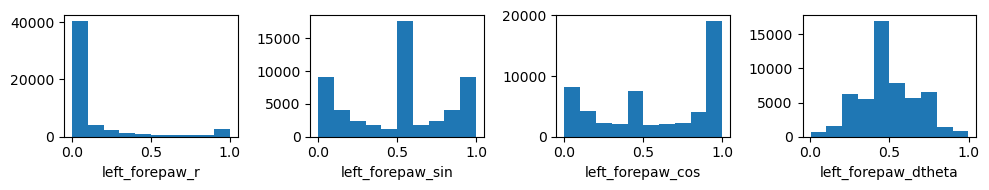

10
right_forepaw_r 0.0 1.0
right_forepaw_sin 0.0 1.0
right_forepaw_cos 0.0 1.0
right_forepaw_dtheta 0.001561582088470459 0.9992421269416809


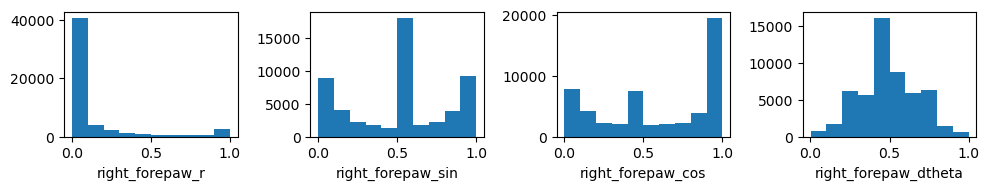

14
center_back_r 0.0 1.0
center_back_sin 0.0 1.0
center_back_cos 0.0 1.0
center_back_dtheta 0.001263052225112915 0.9980109333992004


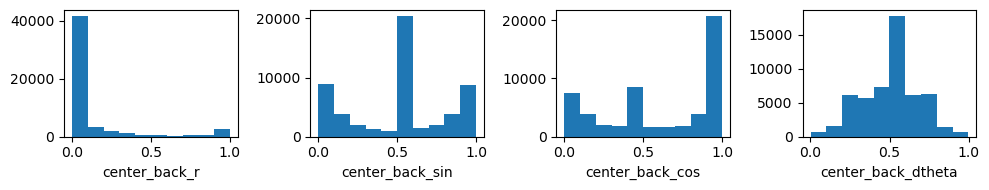

18
left_hindpaw_r 0.0 1.0
left_hindpaw_sin 0.0 1.0
left_hindpaw_cos 0.0 1.0
left_hindpaw_dtheta 0.0012938380241394043 0.9989529848098755


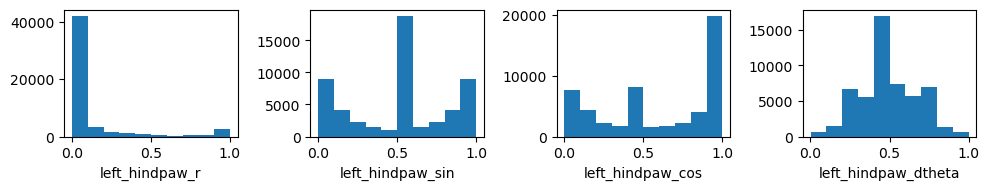

22
right_hindpaw_r 0.0 1.0
right_hindpaw_sin 0.0 1.0
right_hindpaw_cos 0.0 1.0
right_hindpaw_dtheta 0.0014213919639587402 0.9993312954902649


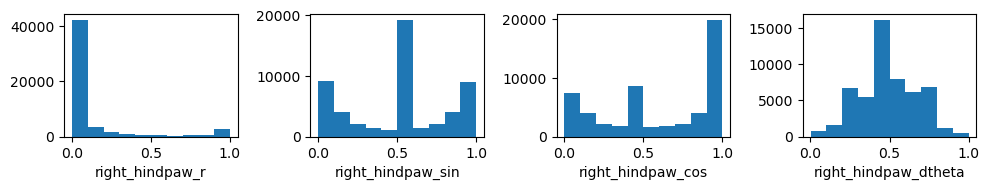

26
tail_base_r 0.0 1.0
tail_base_sin 0.0 1.0
tail_base_cos 0.0 1.0
tail_base_dtheta 0.001263052225112915 0.9986253380775452


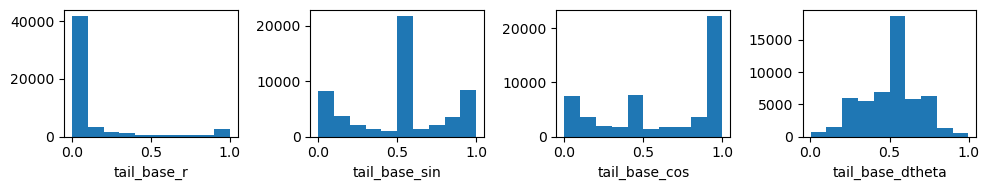

30
tail_middle_r 0.0 1.0
tail_middle_sin 0.0 1.0
tail_middle_cos 0.0 1.0
tail_middle_dtheta 0.002840876579284668 0.9980593919754028


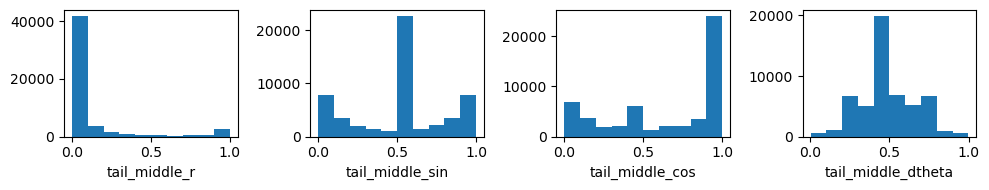

34
tail_tip_r 0.0 1.0
tail_tip_sin 0.0 1.0
tail_tip_cos 0.0 1.0
tail_tip_dtheta 0.0009824037551879883 0.9985264539718628


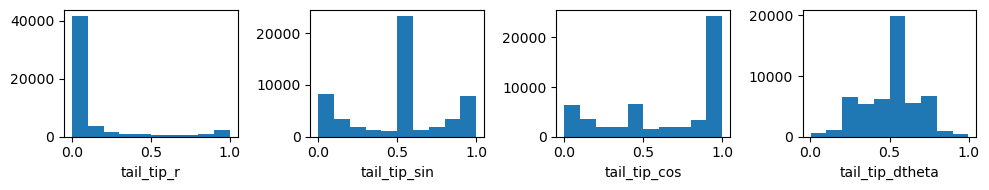

38
head_r 0.0 1.0
head_sin 0.0 1.0
head_cos 0.0 1.0
head_dtheta 0.0008942186832427979 0.9985034465789795


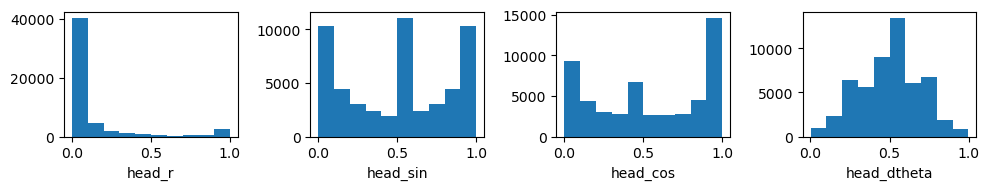

In [20]:

for i in range(2, new_df.shape[1], 4):
    print(i)

    fig, axs = plt.subplots(1, 4, figsize=(10,2))

    ax = axs[0]
    ax.hist(new_df[new_df.columns[i]])
    ax.set_xlabel(new_df.columns[i])
    print(new_df.columns[i], np.min(new_df[new_df.columns[i]]), np.max(new_df[new_df.columns[i]]))

    ax = axs[1]
    ax.hist(new_df[new_df.columns[i+1]])
    ax.set_xlabel(new_df.columns[i+1])
    print(new_df.columns[i+1], np.min(new_df[new_df.columns[i+1]]), np.max(new_df[new_df.columns[i+1]]))

    ax = axs[2]
    ax.hist(new_df[new_df.columns[i+2]])
    ax.set_xlabel(new_df.columns[i+2])
    print(new_df.columns[i+2], np.min(new_df[new_df.columns[i+2]]), np.max(new_df[new_df.columns[i+2]]))

    ax = axs[3]
    ax.hist(new_df[new_df.columns[i+3]])
    ax.set_xlabel(new_df.columns[i+3])
    print(new_df.columns[i+3], np.min(new_df[new_df.columns[i+3]]), np.max(new_df[new_df.columns[i+3]]))

    fig.tight_layout()

    plt.show(fig)
    plt.close(fig)

    #break


In [21]:
new_df

,frame,animal_code,neck_r,neck_sin,neck_cos,neck_dtheta,left_forepaw_r,left_forepaw_sin,left_forepaw_cos,left_forepaw_dtheta,...,tail_middle_cos,tail_middle_dtheta,tail_tip_r,tail_tip_sin,tail_tip_cos,tail_tip_dtheta,head_r,head_sin,head_cos,head_dtheta
0,2,0_0D2SPY7EPE05CRPC8DP0,0.007553,0.146447,0.853553,0.437500,0.097225,0.041921,0.299591,0.217181,...,1.0,0.316082,0.0,0.5,1.0,0.5,0.005629,0.974342,0.341888,0.735250
1,3,0_0D2SPY7EPE05CRPC8DP0,0.059710,0.008065,0.410557,0.423188,0.047565,0.968165,0.675562,0.754269,...,1.0,0.500000,0.0,0.5,1.0,0.5,0.007960,0.723604,0.052785,0.562501
2,4,0_0D2SPY7EPE05CRPC8DP0,0.043058,0.996139,0.562017,0.754416,0.040529,0.019238,0.362639,0.256404,...,1.0,0.500000,0.0,0.5,1.0,0.5,0.001780,0.500000,1.000000,0.286895
3,5,0_0D2SPY7EPE05CRPC8DP0,0.032486,0.006803,0.417801,0.246754,0.011134,0.500000,1.000000,0.647146,...,1.0,0.500000,0.0,0.5,1.0,0.5,0.003980,0.052788,0.276389,0.338103
4,6,0_0D2SPY7EPE05CRPC8DP0,0.049238,0.988093,0.608465,0.745741,0.089247,0.999026,0.531189,0.620033,...,1.0,0.500000,0.0,0.5,1.0,0.5,0.018584,0.021087,0.643674,0.560090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53395,175,2_G1XQ5RO6M8CAVWA81AAT,0.000000,0.500000,1.000000,0.500000,0.000000,0.500000,1.000000,0.500000,...,1.0,0.500000,0.0,0.5,1.0,0.5,0.000000,0.500000,1.000000,0.500000
53396,176,2_G1XQ5RO6M8CAVWA81AAT,0.000000,0.500000,1.000000,0.500000,0.000000,0.500000,1.000000,0.500000,...,1.0,0.500000,0.0,0.5,1.0,0.5,0.000000,0.500000,1.000000,0.500000
53397,177,2_G1XQ5RO6M8CAVWA81AAT,0.000000,0.500000,1.000000,0.500000,0.000000,0.500000,1.000000,0.500000,...,1.0,0.500000,0.0,0.5,1.0,0.5,0.000000,0.500000,1.000000,0.500000
53398,178,2_G1XQ5RO6M8CAVWA81AAT,0.000000,0.500000,1.000000,0.500000,0.000000,0.500000,1.000000,0.500000,...,1.0,0.500000,0.0,0.5,1.0,0.5,0.000000,0.500000,1.000000,0.500000


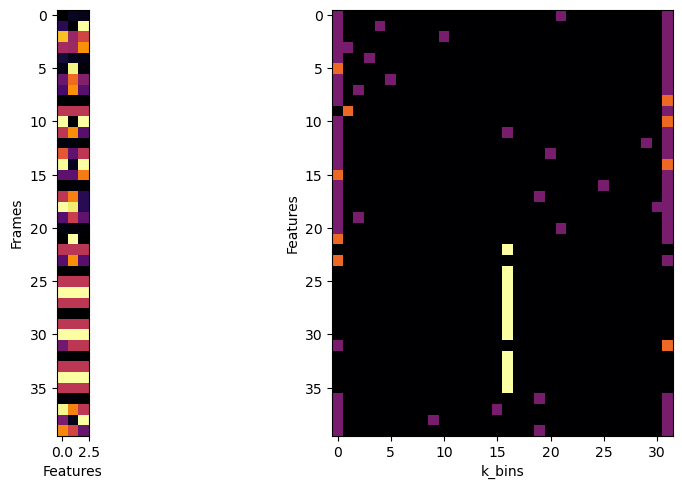

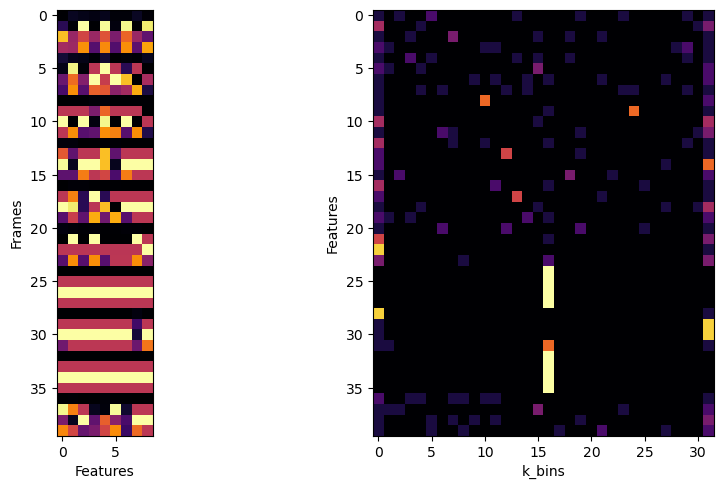

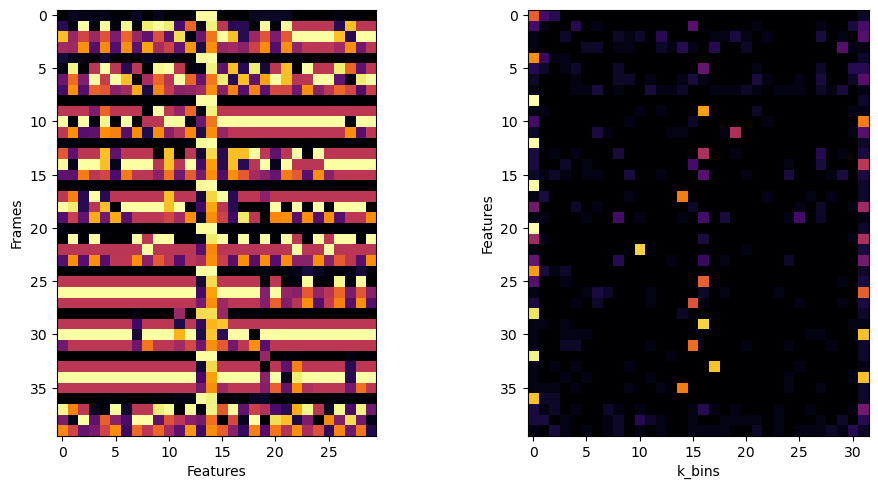

In [36]:
window_sizes = [30, 90, 300]
window_sizes = [int(x/downsample_framerate) for x in window_sizes]
k_bins = 32

show = True

n = 0
for animal in new_df['animal_code'].unique():
    tmp = new_df[new_df['animal_code'] == animal]
    tmp = tmp.iloc[:, 2:]

    windows = [[] for w in window_sizes]
    for i, window_size in enumerate(window_sizes):
        for j in range(0, tmp.shape[0], window_size):
            values = tmp.iloc[j:j+window_size, :].values

            distributions = [np.histogram(values[:, k], bins=k_bins)[0] for k in range(values.shape[1])]
            ## normalize by dividing my the sum
            distributions = [d/np.sum(d) for d in distributions]
            distributions = np.array(distributions)

            windows[i].append(distributions)

            if show == True and j == 0 and i < 3 and n == 0:
                ## show an example of a distribution for each window size compared with the original data

                fig, axs = plt.subplots(1, 2, figsize=(10,5))

                ax = axs[0]
                ax.imshow(values.T, cmap='inferno')
                ax.set_xlabel('Features')
                ax.set_ylabel('Frames')

                ax = axs[1]
                ax.imshow(distributions, cmap='inferno')
                ax.set_ylabel('Features')
                ax.set_xlabel('k_bins')

                fig.tight_layout()

                plt.show(fig)
                plt.close(fig)

    n += 1
    break

In [23]:
new_df.columns

Index(['frame', 'animal_code', 'neck_r', 'neck_sin', 'neck_cos', 'neck_dtheta',
       'left_forepaw_r', 'left_forepaw_sin', 'left_forepaw_cos',
       'left_forepaw_dtheta', 'right_forepaw_r', 'right_forepaw_sin',
       'right_forepaw_cos', 'right_forepaw_dtheta', 'center_back_r',
       'center_back_sin', 'center_back_cos', 'center_back_dtheta',
       'left_hindpaw_r', 'left_hindpaw_sin', 'left_hindpaw_cos',
       'left_hindpaw_dtheta', 'right_hindpaw_r', 'right_hindpaw_sin',
       'right_hindpaw_cos', 'right_hindpaw_dtheta', 'tail_base_r',
       'tail_base_sin', 'tail_base_cos', 'tail_base_dtheta', 'tail_middle_r',
       'tail_middle_sin', 'tail_middle_cos', 'tail_middle_dtheta',
       'tail_tip_r', 'tail_tip_sin', 'tail_tip_cos', 'tail_tip_dtheta',
       'head_r', 'head_sin', 'head_cos', 'head_dtheta'],
      dtype='object')

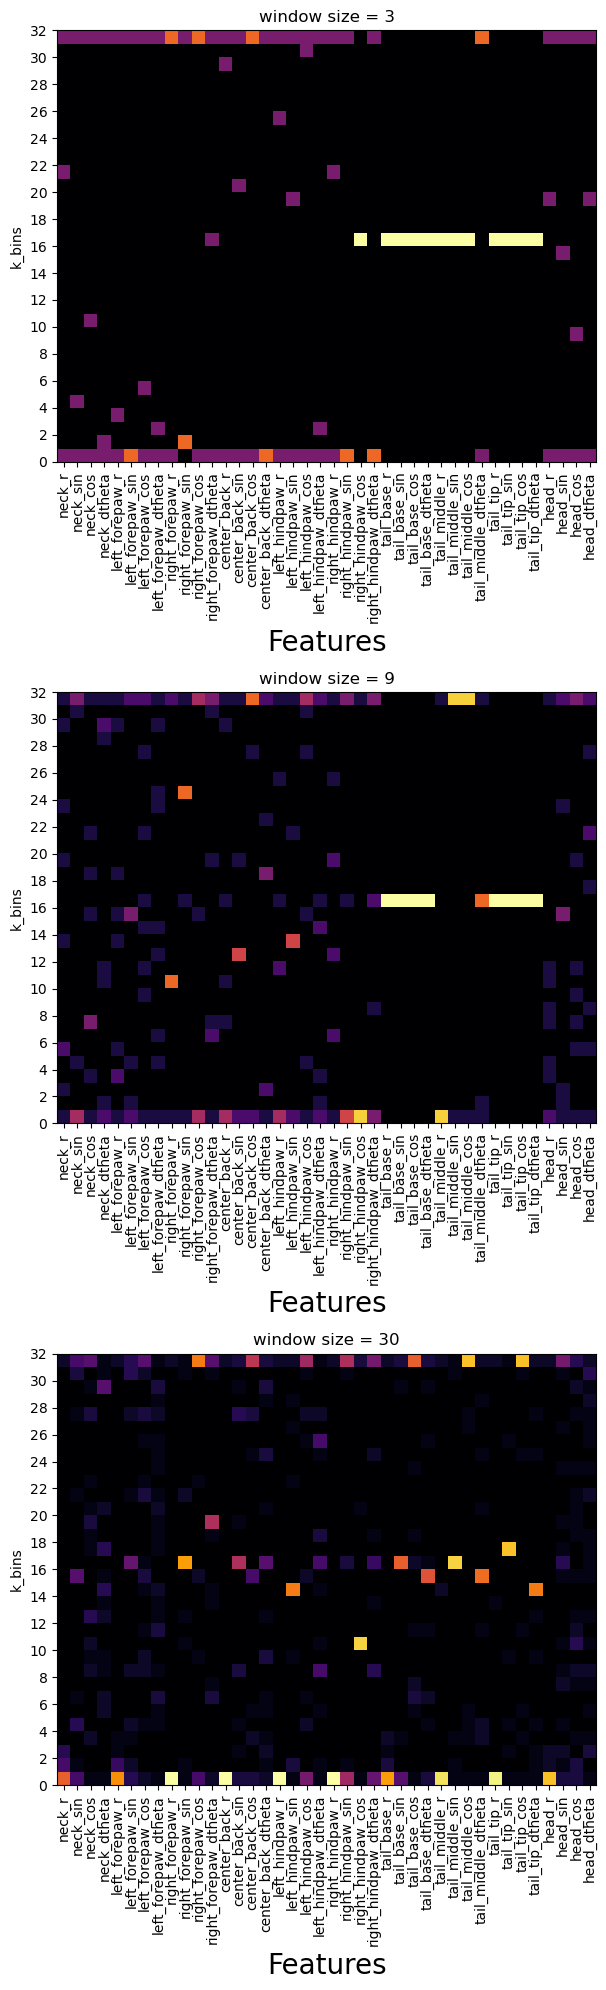

In [24]:
features = new_df.columns[2:]

fig, axs = plt.subplots(3,1, figsize=(20,20))


xlabs = []
xticks = []
n = 0
stepby = 1
for i, feature in enumerate(features[::stepby]):
    xlabs.append(feature)
    xticks.append(n)
    n += stepby

yticks = np.arange(0, k_bins+2, 2)
ylabs = yticks
yticks = yticks - 0.5

for i, window in enumerate(windows):
    ax = axs[i]
    ax.imshow(np.array(window[0]).T, cmap='inferno')
    ax.set_xlabel('Features', fontsize=20)
    ax.set_ylabel('k_bins')
    ax.set_title(f'window size = {window_sizes[i]}')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabs, rotation=90)

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabs)

    ax.set_ylim(-0.5, k_bins-0.5)

fig.tight_layout()

plt.show(fig)
plt.close(fig)

In [25]:
k_bins

32